# Fraud Detection Model

This project builds a machine learning model to detect fraudulent financial transactions.  
The dataset contains **6,362,620 rows and 11 columns**, with the target column `isFraud`.  

**Goal:** Predict fraud proactively and provide actionable recommendations for prevention.  


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score

In [2]:
data = pd.read_csv('Fraud.csv')

In [3]:
data.shape

(6362620, 11)

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
data['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

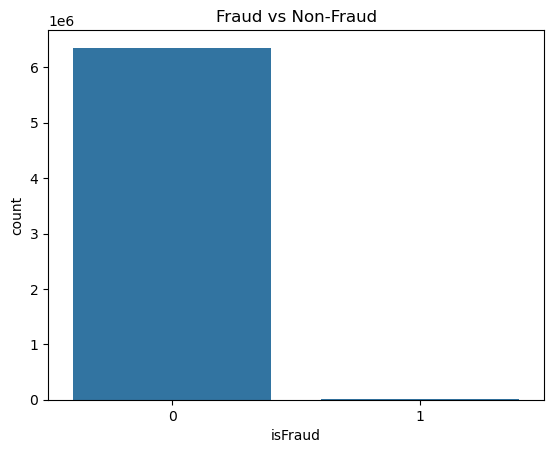

In [8]:
sns.countplot(x='isFraud', data=data)
plt.title("Fraud vs Non-Fraud")
plt.show()

### Fraud Distribution
The dataset is highly **imbalanced**:
- Majority class = Non-fraud 
- Minority class = Fraud  

This imbalance means accuracy alone is **not a useful metric**. We will use **precision, recall, F1, ROC-AUC** to evaluate our models.


In [9]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

### Transaction Types
Most transactions are of type **PAYMENT**, but fraud mostly occurs in **TRANSFER** and **CASH_OUT**.  
This aligns with real-world fraud, where fraudsters try to move money out quickly.


In [10]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
data = data.drop(columns=['nameOrig', 'nameDest'])

In [12]:
data = pd.get_dummies(data, columns=['type'], drop_first=True, dtype=int)

In [13]:
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


### Data Cleaning
- Dropped unique IDs (`nameOrig`, `nameDest`) because they do not provide predictive power.  
- Converted categorical `type` into numeric columns using one-hot encoding.  
- Added new features (`balance_diff_orig`, `balance_diff_dest`) to capture inconsistencies in account balances.


In [14]:
data['balance_diff_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_diff_dest'] = data['oldbalanceDest'] - data['newbalanceDest']

In [15]:
x = data.drop(columns=['isFraud'])
y= data['isFraud']

In [16]:
# x

In [17]:
# y

In [18]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3, random_state=42, stratify=y)

In [19]:
smote = SMOTE(random_state=42, sampling_strategy=0.1)
x_train_res,y_train_res = smote.fit_resample(x_train,y_train)

### Handling Class Imbalance
Since fraud cases are very rare, the model could ignore them.  
To solve this, we used **SMOTE (Synthetic Minority Oversampling Technique)**, which generates synthetic fraud samples in the training set.  

Result:  
- Before SMOTE → Very few fraud cases  
- After SMOTE → Balanced dataset 


In [26]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(x_train_res,y_train_res)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Model Choice: Logistic Regression
We first trained a **Logistic Regression** model as a simple baseline.  

In [27]:
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)[:, 1]

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.92      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.51      0.94      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786



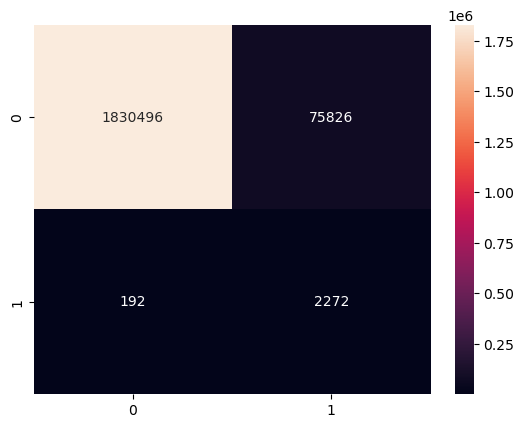

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [30]:
roc_score = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", roc_score)

ROC AUC Score: 0.9854134435324269


### Model Performance
- **Confusion Matrix** shows how many frauds were correctly/incorrectly classified.  
- **Classification Report** provides Precision, Recall, and F1-score.  
- **ROC AUC Score** indicates how well the model separates fraud vs non-fraud across thresholds.  

Key takeaways:  
- High Recall = We catch more fraud cases (good for business).  
- Precision may be lower = More false alarms, but this is acceptable in fraud detection.  


In [31]:
importance = pd.Series(model.coef_[0], index=x.columns)
print(importance.sort_values(ascending=False).head(10))

type_TRANSFER        0.884514
type_CASH_OUT        0.189685
isFlaggedFraud       0.030625
step                 0.005287
balance_diff_orig    0.000021
balance_diff_dest    0.000010
oldbalanceOrg        0.000010
oldbalanceDest       0.000005
amount               0.000001
newbalanceDest      -0.000005
dtype: float64


### Important Features
The most important predictors of fraud include:
- `type_TRANSFER` and `type_CASH_OUT` → fraud is concentrated in these transaction types  
- `amount` → unusually large amounts increase fraud risk  
- `balance_diff_orig` and `balance_diff_dest` → inconsistencies in balances are strong fraud signals  

These results make sense and align with domain knowledge.


# Business Recommendations

- Fraud mostly happens in **TRANSFER** and **CASH_OUT** transactions.  
- Company should add **extra checks** for high-value transactions (e.g., OTP, multi-factor authentication).  
- Use **real-time alerts** to customers for unusual activity.  
 
